### Performance Evaluation ###

In [3]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

# PyTorch
import torch
from torchvision import ops

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh, xywh2xyxy, plot_boxes
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform
from computervision.performance import DetectionMetrics
from computervision.inference import DETRInference

print(f'Project version: {computervision.__version__}')
print(f'Authors: {computervision.__authors__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project version: v0.0.2
Authors: The Core for Computational Biomedicine at Harvard Medical School
https://dbmi.hms.harvard.edu/about-dbmi/core-computational-biomedicine
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [4]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


### Test data ###

In [5]:
# ROBOFLOW DATA
dataset = 'dataset_object_roboflow_240930'
image_dir = os.path.join(os.environ.get('DATA'), dataset)
df_file_name = 'roboflow_240930_dset.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

# Let's get rid of the rows where we do not have positions
# And select the test data
df = df.loc[(~df[pos_col].isnull()) & (df['dset'] == 'test')].\
    reset_index(drop=True)
display(df.head(2))

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)
print(f'Using {len(checked)} images from the Roboflow data set')
print(f'Annotations: {df.shape[0]}')

,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id
0,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[0.0, 2.0, 89.539, 213.0]",tooth 23,teeth,11,8f6469e5a9_454
1,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[73.0, 3.0, 195.099, 219.0]",tooth 24,teeth,12,8f6469e5a9_455


Using 48 images from the Roboflow data set
Annotations: 444


### Model and image processor ###

In [6]:
model_name = 'rtdetr_roboflow_251005_01'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
model_json_name = f'{model_name}.json'
model_json_file = os.path.join(model_dir, model_json_name)

checkpoint_name = 'checkpoint-3800'
checkpoint = os.path.join(model_dir, checkpoint_name)

# Load model parameters
with open(model_json_file, mode='r') as fl:
    model_parameters = json.load(fl)
display(model_parameters.keys())
model_info = model_parameters.get('model_info')

# Category ID to label conversion
id2label = model_parameters.get('id2label')
id2label = {int(k): int(v) for k,v in id2label.items()}

# Load the model
detr = DETRInference(device=device, checkpoint_path=checkpoint, batch_size=4)

dict_keys(['model_info', 'id2label', 'training_args', 'processor_params', 'bbox_format'])

### Predict on the dataset ###

In [19]:
input_width, input_height = model_info.get('im_width'), model_info.get('im_height')

transforms = AugmentationTransform(im_height=input_height, im_width=input_width).get_transforms(name='val')
print(transforms)

dataset = DETRdataset(data=df,
                      image_processor=detr.processor,
                      image_dir=image_dir,
                      file_name_col=file_col,
                      transforms=transforms)

file_list = dataset.file_list
file_name_list = [os.path.basename(file) for file in file_list]
file2id = dict(zip(file_name_list, range(len(file_name_list))))

# Add the image_id column to the data set so that we can correctly assign the predictions
df = df.assign(image_id = df[file_col].apply(lambda file_name: file2id.get(file_name)))
display(df.head(2))

threshold = 0.05
pred_df = detr.predict_on_dataset(dataset=dataset, threshold=0.02)

# Get rid of very small bounding boxes
min_area = 1000
print(pred_df.shape[0])
pred_df = pred_df.loc[pred_df['area'] > min_area]
print(pred_df.shape[0])
display(pred_df.head(2))

[NoOp(p=1.0), AutoContrast(p=1.0, cutoff=0.0, ignore=None, method='cdf'), CLAHE(p=1.0, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))]


,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id,image_id
0,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[0.0, 2.0, 89.539, 213.0]",tooth 23,teeth,11,8f6469e5a9_454,0
1,35,1,may2015-pbws-completed__7d580ea59bea307746203b...,480,640,2024-09-17T23:44:33+00:00,8f6469e5a9,test,8f6469e5a9.jpg,"[73.0, 3.0, 195.099, 219.0]",tooth 24,teeth,12,8f6469e5a9_455,0


Predicting batch 10 of 12.
1204
1121


,image_id,image_width,image_height,batch,category_id,bbox,score,area
0,0,640,480,0,18,"[283, 184, 356, 175]",0.98351,62300
1,0,640,480,0,19,"[143, 185, 292, 174]",0.976211,50808


True: [2, 3, 4, 5, 6, 31, 30, 29, 28]
Pred: [6, 2, 4, 30, 31, 5, 3, 28, 29, 20, 12, 19, 30, 19, 18]


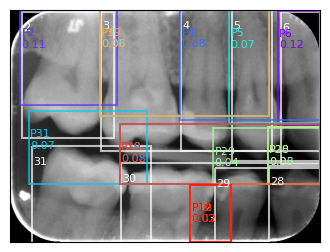

In [27]:
figsize = (4, 4)
idx = 10
file = file_list[idx]
file_name = os.path.basename(file)
    
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
df_file = df.loc[df[file_col] == file_name]
bbox_list = df_file[bbox_col].tolist()
pos_list = df_file[pos_col].tolist()
    
# Predict positions
output = pred_df.loc[pred_df['image_id'] == idx]
image_width = output.get('image_width').tolist()[0]
image_height = output.get('image_height').tolist()[0]
xlim=(0, image_width)
ylim=(0, image_height)

if output is not None:
    output_bbox_list = output.get('bbox')
    output_bbox_list = [clipxywh(list(box), xlim=(0, image_width), ylim=(0, image_height)) for box in output_bbox_list]
    output_cat_list = output.get('category_id')
    output_pos_list = [id2label.get(cat) for cat in output_cat_list]
    score_list = output.get('score')
    output_label_list = [f'P{p}\n{s:.2f}' for p, s in zip(output_pos_list, score_list)]

    print(f'True: {pos_list}')
    print(f'Pred: {output_pos_list}')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=pos_list, color='w', ax=ax)
    ax = plot_boxes(image=im, box_list=output_bbox_list, label_list=output_label_list, ax=ax, offset_xy=(0, 100))
    plt.show()

[45, 281, 246, 199]
31
[39, 209, 243, 150]


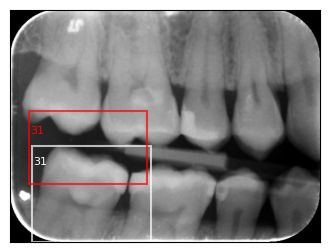

IoU for label 31: 0.2762485444545746


In [29]:
# Let's pick one ground truth and one predicted position
# So we can calculate the iou
true_pos = 31
true_bbx = list(bbox_list[pos_list.index(true_pos)])
true_bbx = clipxywh(true_bbx, xlim=xlim, ylim=ylim, decimals=0)
print(true_bbx)

pred_pos_idx = output_pos_list.index(true_pos)
pred_pos = output_pos_list[pred_pos_idx]
print(pred_pos)
pred_bbx = output_bbox_list[pred_pos_idx]
print(pred_bbx)

# Plot this situation
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=[true_bbx], label_list=[true_pos], ax=ax, color='w')
ax = plot_boxes(image=im, box_list=[pred_bbx], label_list=[pred_pos], ax=ax, color='r', offset_xy=(0, 20))
plt.show()

# Calculate the IoU for the predicted bounding box and the ground truth
iou = DetectionMetrics.compute_iou(bbox_1=true_bbx, bbox_2=pred_bbx, bbox_format='xywh', method='pt')
print(f'IoU for label {true_pos}: {iou}')

### Classify predictions ###
In object detection, AP (Average Precision) scores are calculated based on the area under a precision-recall curve and are used to evaluate model performance. The overall model performance across all object classes is summarized by the mAP (mean Average Precision). [1, 2, 3, 4]  
Here is a step-by-step breakdown of how to calculate AP scores for object detection: [5, 6]  
1. Calculate Intersection over Union (IoU) IoU measures the overlap between a predicted bounding box and its corresponding ground truth bounding box. The score is used to determine whether a detection is correct or not. [7, 8, 9, 10]  
The formula for IoU is: 

• Intersection: The area of overlap between the predicted and ground truth boxes. 
• Union: The total area covered by both bounding boxes combined. [9, 11, 12, 13]  

2. Determine True Positives, False Positives, and False Negatives Using a pre-defined IoU threshold (e.g., 0.5), classify each prediction as a True Positive (TP), False Positive (FP), or False Negative (FN). 

• True Positive (TP): A correct detection. This happens when a predicted bounding box has an IoU greater than or equal to the threshold and the correct class label. 
• False Positive (FP): An incorrect detection. This can be a predicted box with an IoU below the threshold, or a duplicate detection of an object already counted as a TP. 
• False Negative (FN): A missed ground truth object. This occurs when the model fails to detect an object that is present in the image. 
• Note: True Negatives (correctly identifying the background) are not used in AP calculation. [6, 14, 15, 16, 17]  

3. Calculate precision and recall Precision and recall are calculated at each unique confidence score output by the model across the entire dataset. To do this, predictions are sorted in descending order based on their confidence score. 

• Precision: The ratio of true positive predictions to the total number of positive predictions. A high precision score means the model is accurate when it does predict an object. 
• Recall: The ratio of true positive predictions to the total number of actual positive objects. A high recall score means the model successfully finds most of the relevant objects. [18, 19, 20]  

4. Create the precision-recall curve Plot the calculated precision and recall values for each class, with recall on the x-axis and precision on the y-axis. The shape of the curve reveals the trade-off between precision and recall at different confidence thresholds. A good model will maintain high precision as recall increases. [21, 22, 23, 24, 25]  
5. Calculate Average Precision (AP) The Average Precision (AP) for a single class is the area under its precision-recall curve. This provides a single-value summary of performance for that class. [3, 6, 21]  
Historically, different methods have been used to compute this area: 

• 11-Point Interpolation (PASCAL VOC 2008): Averages the precision values at 11 specific recall levels (0.0, 0.1, ..., 1.0). 
• All-Point Interpolation (PASCAL VOC 2010+ and modern methods): Integrates the area under all points of the precision-recall curve for a more accurate calculation. [23, 26, 27, 28, 29]  

6. Calculate mean Average Precision (mAP) mAP is the final evaluation metric and is simply the average of the AP scores across all object classes in the dataset. This gives an overall performance score for the model. [1, 3, 21, 30, 31]  
Some benchmarks, like the Common Objects in Context (COCO) challenge, use a more complex mAP calculation that averages AP scores across multiple IoU thresholds (from 0.5 to 0.95) and all object classes. [2]  

AI responses may include mistakes.

[1] https://www.lightly.ai/blog/mean-average-precision
[2] https://www.v7labs.com/blog/mean-average-precision
[3] https://www.lightly.ai/blog/mean-average-precision
[4] https://docs.ultralytics.com/guides/yolo-performance-metrics/
[5] https://www.digitalocean.com/community/tutorials/mean-average-precision
[6] https://medium.com/data-science/what-is-average-precision-in-object-detection-localization-algorithms-and-how-to-calculate-it-3f330efe697b
[7] https://www.ultralytics.com/glossary/intersection-over-union-iou
[8] https://www.lightly.ai/blog/intersection-over-union
[9] https://xailient.com/blog/what-is-mean-average-precision-and-how-does-it-work/
[10] https://www.oreilly.com/library/view/hands-on-convolutional-neural/9781789130331/a0267a8a-bd4a-452a-9e5a-8b276d7787a0.xhtml
[11] https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/
[12] https://www.v7labs.com/blog/yolo-object-detection
[13] https://www.einfochips.com/blog/understanding-object-localization-with-deep-learning/
[14] https://bioresources.cnr.ncsu.edu/resources/a-fast-and-robust-artificial-intelligence-technique-for-wood-knot-detection/
[15] https://www.nature.com/articles/s41598-025-86323-1
[16] https://www.fuzzylabs.ai/blog-post/mlops-pipeline-on-the-edge
[17] https://www.cell.com/heliyon/fulltext/S2405-8440(25)01761-X
[18] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[19] https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/how-compute-accuracy-for-object-detection-works.htm
[20] https://www.linkedin.com/pulse/choosing-right-metrics-recall-precision-pr-curve-roc-juan-carlos-cfeef
[21] https://www.lightly.ai/blog/mean-average-precision
[22] https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248
[23] https://github.com/rafaelpadilla/Object-Detection-Metrics
[24] https://arxiv.org/html/2307.02694v3
[25] https://www.researchgate.net/publication/387286580_Machine_Learning-Based_Network_Intrusion_Detection_for_IOT_and_Smart_Detection_Using_Recursive_Feature_Elimination_Binning_Technique_and_Grid_Search_CV
[26] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[27] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[28] https://www.superannotate.com/blog/mean-average-precision-and-its-uses-in-object-detection
[29] http://vision.uamt.feec.vutbr.cz/ROZ/lectures/MachineLearning_mAP.pdf
[30] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[31] https://arxiv.org/html/2302.10473v4



True labels:        [2, 3, 4, 5, 6, 28, 29, 30, 31]
Pred labels:        [2, 3, 4, 5, 6, 19, 20, 28, 29, 30, 31]
Missed predictions: []
Prediction for label 1/11: 6: TP with IoU: 0.667890191078186


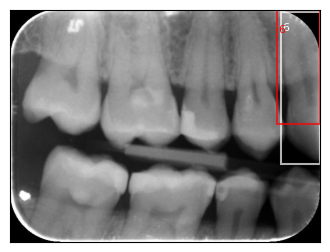

Prediction for label 2/11: 2: TP with IoU: 0.7060838937759399


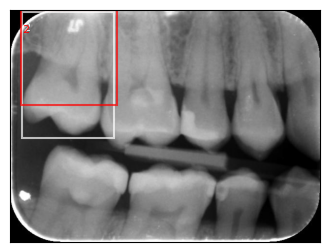

Prediction for label 3/11: 4: TP with IoU: 0.776006817817688


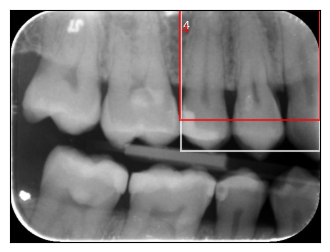

Prediction for label 4/11: 30: FP with IoU: 0.17164164781570435


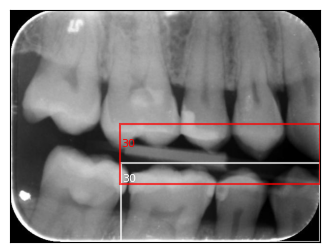

Prediction for label 5/11: 31: FP with IoU: 0.27500486373901367


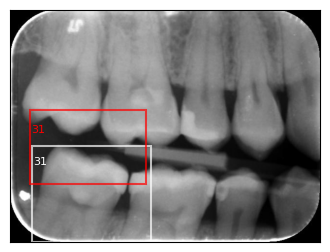

Prediction for label 6/11: 5: TP with IoU: 0.7236024737358093


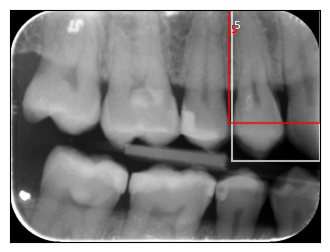

Prediction for label 7/11: 28: FP with IoU: 0.14762164652347565


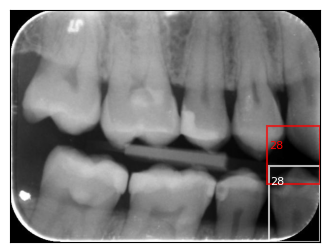

Prediction for label 8/11: 3: TP with IoU: 0.7476420998573303


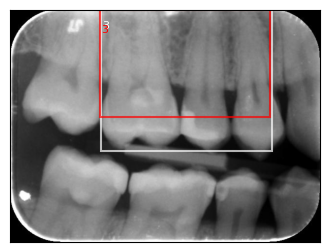

Prediction for label 9/11: 29: FP with IoU: 0.13428138196468353


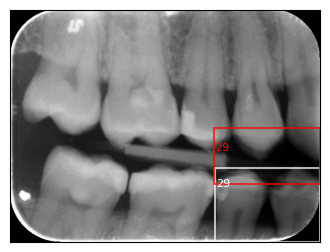

[6, 2, 4, 30, 31, 5, 28, 3, 29, 20, 19]
[2, 3, 4, 5, 6, 31, 30, 29, 28]
[0.667890191078186, 0.7060838937759399, 0.776006817817688, 0.17164164781570435, 0.27500486373901367, 0.7236024737358093, 0.14762164652347565, 0.7476420998573303, 0.13428138196468353, nan, nan]
['TP', 'TP', 'TP', 'FP', 'FP', 'TP', 'FP', 'TP', 'FP', 'FP', 'FP']


,pred_label,TP,score,IoU,duplicate_TP
0,2,TP,0.1059,0.706084,False
1,3,TP,0.0558,0.747642,False
2,4,TP,0.0885,0.776007,False
3,5,TP,0.0612,0.723602,False
4,6,TP,0.1293,0.667890,False
5,19,FP,0.0250,NaN,False
6,20,FP,0.0292,NaN,False
7,28,FP,0.0563,0.147622,False
8,29,FP,0.0401,0.134281,False
9,30,FP,0.0766,0.171642,False


In [30]:
# Performance evaluations
score_threshold = 0.02
iou_threshold = 0.5
min_area = 10000
x_lim = (0, im.shape[1])
y_lim = (0, im.shape[0])

# Ground truth
true_labels = [int(l) for l in df_file[pos_col].tolist()]
true_bboxes = df_file[bbox_col].tolist()
true_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in true_bboxes]

print(f'True labels:        {sorted(true_labels)}')

# Predictions
output = detr.predict_on_image(image=im, threshold=score_threshold)
output_df = pd.DataFrame(output)
output_df = output_df.loc[output_df['area'] > min_area]
output_df = output_df.sort_values(by=['score'], ascending=False).reset_index(drop=True)
pred_labels = [int(id2label.get(cat)) for cat in output_df['category_id'].tolist()]
pred_bboxes = output_df['bbox'].tolist()
pred_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in pred_bboxes]
pred_scores = output_df['score'].tolist()
print(f'Pred labels:        {sorted(pred_labels)}')

# Determine the false negative samples
# Predictions that were missed by the object detection
missed = sorted(list(set(true_labels).difference(pred_labels)))
print(f'Missed predictions: {missed}')

# We want to classify the predictions
iou_list = []
prediction_list = []
for p, p_label in enumerate(pred_labels):
    
    p_bbox = pred_bboxes[p]
    
    # When there is no label for this prediction, it is a FP prediction
    # NOTE: the FP numbers will be too high if not all of the instances are labeled!
    p_prediction = 'FP'
    p_iou = np.nan
    
    # Let's check each ground truth labels if we have a match
    pt_iou_list = []
    t_bbx_list = []
    
    for t, t_label in enumerate(true_labels):
        if p_label == t_label:
            t_bbox = true_bboxes[t]
            pt_iou = DetectionMetrics.compute_iou(p_bbox, t_bbox, bbox_format='xywh', method='pt')
            pt_iou_list.append(pt_iou)
            t_bbx_list.append(t_bbox)
            
    if len(pt_iou_list) > 0:
        p_iou = np.max(pt_iou_list)
        t_bbx = t_bbx_list[np.argmax(pt_iou_list)]
        if p_iou >= iou_threshold:
            p_prediction = 'TP'
        
        print(f'Prediction for label {p + 1}/{len(pred_labels)}: {p_label}: {p_prediction} with IoU: {p_iou}')
        
        # Plot the situation when we have a match
        fig, ax = plt.subplots(figsize=figsize)
        ax = plot_boxes(image=im, box_list=[t_bbx], label_list=[p_label], ax=ax, color='w')
        ax = plot_boxes(image=im, box_list=[p_bbox], label_list=[p_label], ax=ax, color='r', offset_xy=(0, 20))
        plt.show()

    iou_list.append(p_iou)
    prediction_list.append(p_prediction)

# What if we predict the same class twice and both are TP?
# We count only the first one as a TP, the others we set to FP.
c = pd.DataFrame({'pred_label': pred_labels,
                  'TP': prediction_list,
                  'score': pred_scores,
                  'IoU': iou_list})

c = c.assign(duplicate_TP=False)

# Flip duplicate TP predictions
d = c.copy()
d.loc[(c.duplicated(subset=['pred_label', 'TP'])) & (c['TP'] == 'TP'), 'TP'] = 'FP'
d.loc[(c.duplicated(subset=['pred_label', 'TP'])) & (c['TP'] == 'TP'), 'duplicate_TP'] = True

d = d.sort_values(by=['pred_label', 'score'], ascending=True).reset_index(drop=True)

print(pred_labels)
print(true_labels)
print(iou_list)
print(prediction_list)
display(d)

### Prediction classification method ###

In [32]:
def classify_predictions(true_labels, true_bboxes, pred_labels, pred_bboxes, iou_threshold):

    # Make sure that the true and pred labels have the same type
    assert all([isinstance(true_labels, list), isinstance(pred_labels, list)])
    assert all([isinstance(true_bboxes, list), isinstance(pred_bboxes, list)])
    
    # Missed predictions (FN)
    missed = sorted(list(set(true_labels).difference(pred_labels)))
    # Classify predictions (TP:1, FP:0)
    iou_list = []
    prediction_list = []
    for p, p_label in enumerate(pred_labels):
        p_bbox = pred_bboxes[p]
        p_prediction = 0 # FP
        p_iou = np.nan
        pt_iou_list = []
        for t, t_label in enumerate(true_labels):
            if p_label == t_label:
                t_bbox = true_bboxes[t]
                pt_iou = DetectionMetrics.compute_iou(p_bbox, t_bbox, bbox_format='xywh', method='pt')
                pt_iou_list.append(pt_iou)
        if len(pt_iou_list) > 0:
            p_iou = np.max(pt_iou_list)
            if p_iou >= iou_threshold:
                p_prediction = 1 # TP
        prediction_list.append(p_prediction)
        iou_list.append(p_iou)
    
    pred_df = pd.DataFrame({'pred_label': pred_labels,
                            'TP': prediction_list,
                            'IoU': iou_list})
    
    pred_df = pred_df.assign(FN=len(missed),
                             duplicate_TP=False)
    
    output_df = pred_df.copy()
    # Flipt duplicate TP predictions for the same label with FP
    output_df.loc[(pred_df.duplicated(subset=['pred_label', 'TP'])) & (pred_df['TP'] == 1), 'TP'] = 0
    output_df.loc[(pred_df.duplicated(subset=['pred_label', 'TP'])) & (pred_df['TP'] == 1), 'duplicate_TP'] = True

    return missed, output_df

In [33]:
# Input
true_labels = df_file[pos_col].tolist()
true_labels = [int(l) for l in true_labels]
true_bboxes = df_file[bbox_col].tolist()
true_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in true_bboxes]

pred_labels = [int(id2label.get(cat)) for cat in output_df.get('category_id').tolist()]
pred_bboxes = output_df.get('bbox').tolist()
pred_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in pred_bboxes]
scores = output_df.get('score').tolist()

print(f'True labels: {true_labels}')
print(f'Pred labels: {pred_labels}')

missed, predictions_df = DetectionMetrics.\
    classify_predictions(true_labels=true_labels, 
                         true_bboxes=true_bboxes, 
                         pred_labels=pred_labels, 
                         pred_bboxes=pred_bboxes, 
                         iou_threshold=iou_threshold)

print(f'Missed labels (FN): {missed}')
display(predictions_df)

True labels: [2, 3, 4, 5, 6, 31, 30, 29, 28]
Pred labels: [6, 2, 4, 30, 31, 5, 28, 3, 29, 20, 19]
Missed labels (FN): []


,pred_label,TP,IoU,FN,duplicate_TP
0,6,1,0.667890,0,False
1,2,1,0.706084,0,False
2,4,1,0.776007,0,False
3,30,0,0.171642,0,False
4,31,0,0.275005,0,False
5,5,1,0.723602,0,False
6,28,0,0.147622,0,False
7,3,1,0.747642,0,False
8,29,0,0.134281,0,False
9,20,0,NaN,0,False
